In [ ]:
!pip install tensorflow

In [ ]:
!nvidia-smi

Wed May 14 06:19:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

#CNN(Assignment I)

Datasets : Traffic Lights -2

Module Leader : Mr. Siman Giri

#Team Members

1)NoilChitrakar (Group Leader)

2)Nishan Prajapati

3)Bibash Charan raya

4)Prashant Khatri

---



#PART A – STEP 1: Dataset Setup, Loading & Exploration

 1.1 Import Required Libraries

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import pathlib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')
import warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive


1.1 Mount Google Drive and Set Paths

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Set paths
data_dir = "/content/drive/MyDrive/Colab Notebooks/Traffic_Sign_-2/"
train_dir = os.path.join(data_dir, "Train")
test_dir = os.path.join(data_dir, "Test")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1.3 Verify and Remove Corrupted Images (Train Folder Only)

In [ ]:
from PIL import Image
import os

def is_image_valid(image_path):
    try:
        img = Image.open(image_path)
        img.verify()
        return True
    except (IOError, SyntaxError):
        return False

# Only clean TRAIN images — test will be handled later for inference
for label in os.listdir(train_dir):
    label_path = os.path.join(train_dir, label)
    if not os.path.isdir(label_path):
        continue
    for img_name in os.listdir(label_path):
        img_path = os.path.join(label_path, img_name)
        if not is_image_valid(img_path):
            print(f"Removing corrupted image: {img_path}")
            os.remove(img_path)
#loops through every training image
#deletes files that cant be opened or decoded

STEP 1.3: Load Images Using ImageDataGenerator (with Augmentation + Validation Split)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# Save class label map
class_labels = list(train_generator.class_indices.keys())
print("Class Labels:", class_labels)


Found 12861 images belonging to 5 classes.
Found 3214 images belonging to 5 classes.
Class Labels: ['Cautions', 'Crossings', 'DIrection', 'No Entry', 'SpeedLimit']


1.4 Show Augmented Image Samples

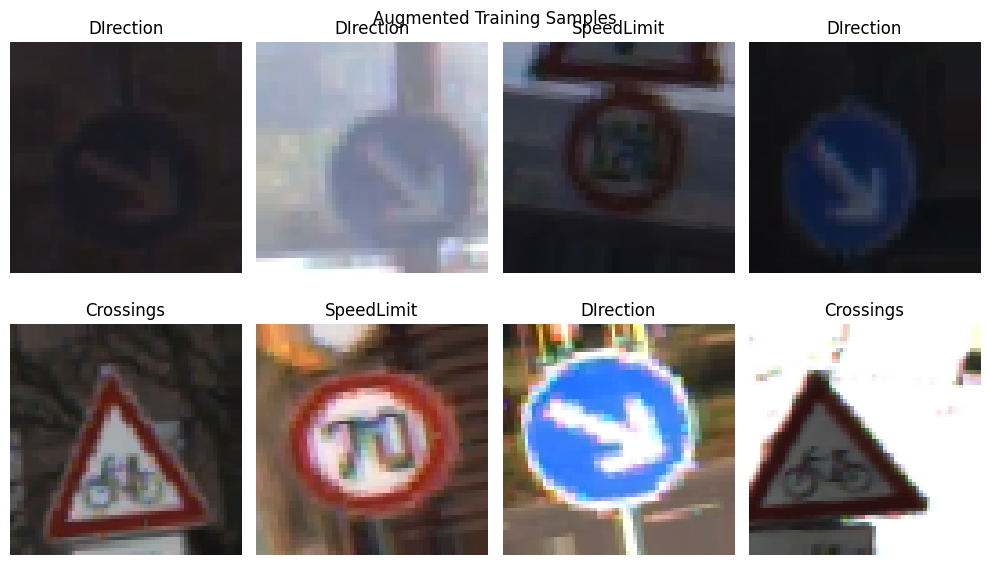

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

images, labels = next(train_generator)

plt.figure(figsize=(10,6))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(images[i])
    plt.title(class_labels[np.argmax(labels[i])])
    plt.axis('off')
plt.tight_layout()
plt.suptitle("Augmented Training Samples")
plt.show()


# 2. Baseline CNN Model (From Scratch)

##2.1  Define the Baseline Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Defining the model architecture
baseline_model = Sequential([
    # Convolutional Layer 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional Layer 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional Layer 3
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    # Fully Connected Layer 1
    Dense(128, activation='relu'),
    Dropout(0.3),

    # Fully Connected Layer 2
    Dense(64, activation='relu'),
    Dropout(0.3),

    # Fully Connected Layer 3
    Dense(32, activation='relu'),

    # Output Layer (Softmax for 5 classes)
    Dense(5, activation='softmax')
])

# Compile the model
baseline_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print the summary
baseline_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 693,701 (2.65 MB)

 Trainable params: 693,701 (2.65 MB)

 Non-trainable params: 0 (0.00 B)

2.2 Setting Up EarlyStopping and ModelCheckpoint



In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Where to save the best model
checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/baseline_best_model.h5"

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)
]


2.3 Train the Model

In [ ]:
EPOCHS = 30

history = baseline_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/30
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.6086 - loss: 0.9970
Epoch 1: val_accuracy improved from -inf to 0.83354, saving model to /content/drive/MyDrive/Colab Notebooks/baseline_best_model.h5


402/402 ━━━━━━━━━━━━━━━━━━━━ 82s 185ms/step - accuracy: 0.6089 - loss: 0.9962 - val_accuracy: 0.8335 - val_loss: 0.3442
Epoch 2/30
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.8812 - loss: 0.2461
Epoch 2: val_accuracy improved from 0.83354 to 0.87897, saving model to /content/drive/MyDrive/Colab Notebooks/baseline_best_model.h5


402/402 ━━━━━━━━━━━━━━━━━━━━ 80s 198ms/step - accuracy: 0.8812 - loss: 0.2461 - val_accuracy: 0.8790 - val_loss: 0.2483
Epoch 3/30
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9221 - loss: 0.1814
Epoch 3: val_accuracy did not improve from 0.87897
402/402 ━━━━━━━━━━━━━━━━━━━━ 70s 169ms/step - accuracy: 0.9221 - loss: 0.1813 - val_accuracy: 0.8755 - val_loss: 0.4126
Epoch 4/30
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9600 - loss: 0.1163
Epoch 4: val_accuracy did not improve from 0.87897
402/402 ━━━━━━━━━━━━━━━━━━━━ 70s 175ms/step - accuracy: 0.9600 - loss: 0.1162 - val_accuracy: 0.8787 - val_loss: 0.5141
Epoch 5/30
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9834 - loss: 0.0560
Epoch 5: val_accuracy did not improve from 0.87897
402/402 ━━━━━━━━━━━━━━━━━━━━ 70s 174ms/step - accuracy: 0.9834 - loss: 0.0559 - val_accuracy: 0.8665 - val_loss: 0.7164
Epoch 6/30
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9818 - loss: 0.0505
Epoch 6: val_ac

402/402 ━━━━━━━━━━━━━━━━━━━━ 88s 189ms/step - accuracy: 0.9818 - loss: 0.0505 - val_accuracy: 0.8821 - val_loss: 0.6193
Epoch 7/30
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9876 - loss: 0.0376
Epoch 7: val_accuracy did not improve from 0.88208
402/402 ━━━━━━━━━━━━━━━━━━━━ 67s 166ms/step - accuracy: 0.9876 - loss: 0.0376 - val_accuracy: 0.8790 - val_loss: 0.6733
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.


2.4 Plot Accuracy & Loss Curves

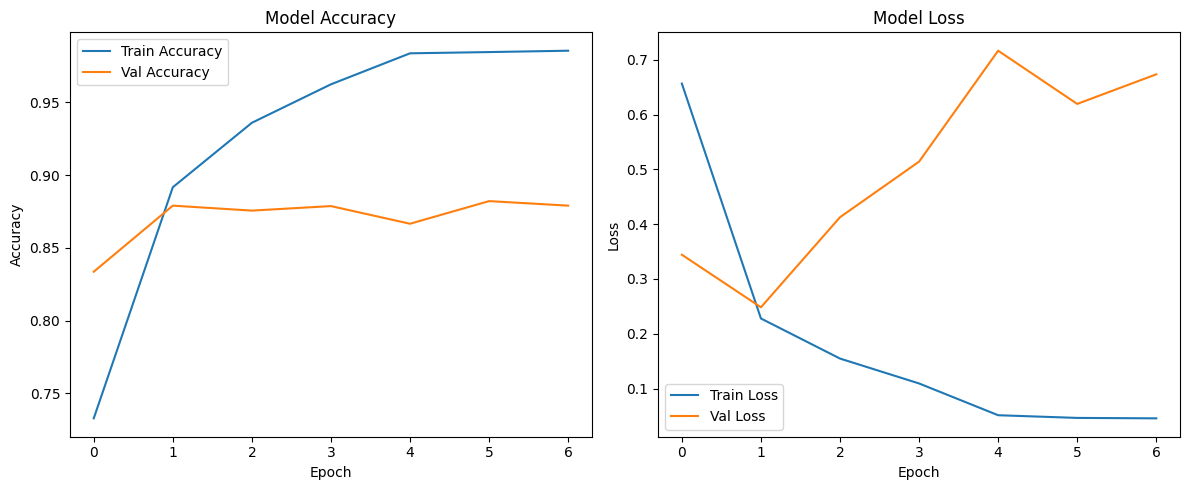

In [ ]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


2.5 Evaluate Model on Validation Set

In [ ]:
val_loss, val_accuracy = baseline_model.evaluate(val_generator)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")


101/101 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - accuracy: 0.8817 - loss: 0.2498
Validation Accuracy: 0.8799
Validation Loss: 0.2539


#3. Deeper CNN Architecture (+ Regularization)

3.1 Define the Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense,
                                     Dropout, BatchNormalization)
from tensorflow.keras.optimizers import Adam

deeper_model = Sequential([

    # Block 1
    Conv2D(32, (3,3), padding='same', activation='relu',
           input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    BatchNormalization(),
    Conv2D(32, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    # Block 2
    Conv2D(64, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.30),

    # Block 3
    Conv2D(128, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.35),

    # Block 4 (extra depth)
    Conv2D(256, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.40),

    Flatten(),

    # FC layers
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64,  activation='relu'),

    # Output
    Dense(5, activation='softmax')
])

deeper_model.compile(
    optimizer=Adam(learning_rate=0.0005),        # slightly lower LR for deeper net
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

deeper_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,675,301 (6.39 MB)

 Trainable params: 1,673,893 (6.39 MB)

 Non-trainable params: 1,408 (5.50 KB)

3.2 Callbacks (EarlyStopping + Checkpoint)

In [ ]:
deep_ckpt_path = "/content/drive/MyDrive/Colab Notebooks/deeper_best_model.h5"

deep_callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    ModelCheckpoint(deep_ckpt_path, monitor='val_accuracy',
                    save_best_only=True, verbose=1)
]


3.3 Train the Deeper Model

In [ ]:
DEEP_EPOCHS = 40   # patience=6 will stop earlier if no val_loss improvement

deep_history = deeper_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=DEEP_EPOCHS,
    callbacks=deep_callbacks
)


Epoch 1/40
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.4446 - loss: 1.7037
Epoch 1: val_accuracy improved from -inf to 0.45022, saving model to /content/drive/MyDrive/Colab Notebooks/deeper_best_model.h5


402/402 ━━━━━━━━━━━━━━━━━━━━ 97s 200ms/step - accuracy: 0.4449 - loss: 1.7026 - val_accuracy: 0.4502 - val_loss: 1.2298
Epoch 2/40
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.7956 - loss: 0.5290
Epoch 2: val_accuracy improved from 0.45022 to 0.86994, saving model to /content/drive/MyDrive/Colab Notebooks/deeper_best_model.h5


402/402 ━━━━━━━━━━━━━━━━━━━━ 69s 173ms/step - accuracy: 0.7957 - loss: 0.5287 - val_accuracy: 0.8699 - val_loss: 0.2847
Epoch 3/40
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8878 - loss: 0.2300
Epoch 3: val_accuracy did not improve from 0.86994
402/402 ━━━━━━━━━━━━━━━━━━━━ 80s 168ms/step - accuracy: 0.8879 - loss: 0.2300 - val_accuracy: 0.8077 - val_loss: 0.6361
Epoch 4/40
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9213 - loss: 0.1822
Epoch 4: val_accuracy improved from 0.86994 to 0.89266, saving model to /content/drive/MyDrive/Colab Notebooks/deeper_best_model.h5


402/402 ━━━━━━━━━━━━━━━━━━━━ 70s 174ms/step - accuracy: 0.9214 - loss: 0.1821 - val_accuracy: 0.8927 - val_loss: 0.3859
Epoch 5/40
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9649 - loss: 0.1093
Epoch 5: val_accuracy did not improve from 0.89266
402/402 ━━━━━━━━━━━━━━━━━━━━ 81s 170ms/step - accuracy: 0.9649 - loss: 0.1093 - val_accuracy: 0.8678 - val_loss: 0.4787
Epoch 6/40
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9773 - loss: 0.0832
Epoch 6: val_accuracy did not improve from 0.89266
402/402 ━━━━━━━━━━━━━━━━━━━━ 81s 169ms/step - accuracy: 0.9773 - loss: 0.0831 - val_accuracy: 0.8815 - val_loss: 0.4185
Epoch 7/40
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9859 - loss: 0.0444
Epoch 7: val_accuracy improved from 0.89266 to 0.89484, saving model to /content/drive/MyDrive/Colab Notebooks/deeper_best_model.h5


402/402 ━━━━━━━━━━━━━━━━━━━━ 82s 169ms/step - accuracy: 0.9859 - loss: 0.0444 - val_accuracy: 0.8948 - val_loss: 0.9413
Epoch 8/40
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9909 - loss: 0.0303
Epoch 8: val_accuracy improved from 0.89484 to 0.90635, saving model to /content/drive/MyDrive/Colab Notebooks/deeper_best_model.h5


402/402 ━━━━━━━━━━━━━━━━━━━━ 69s 172ms/step - accuracy: 0.9909 - loss: 0.0303 - val_accuracy: 0.9063 - val_loss: 0.5665
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 2.


3.4 Plot Training vs Validation Curves

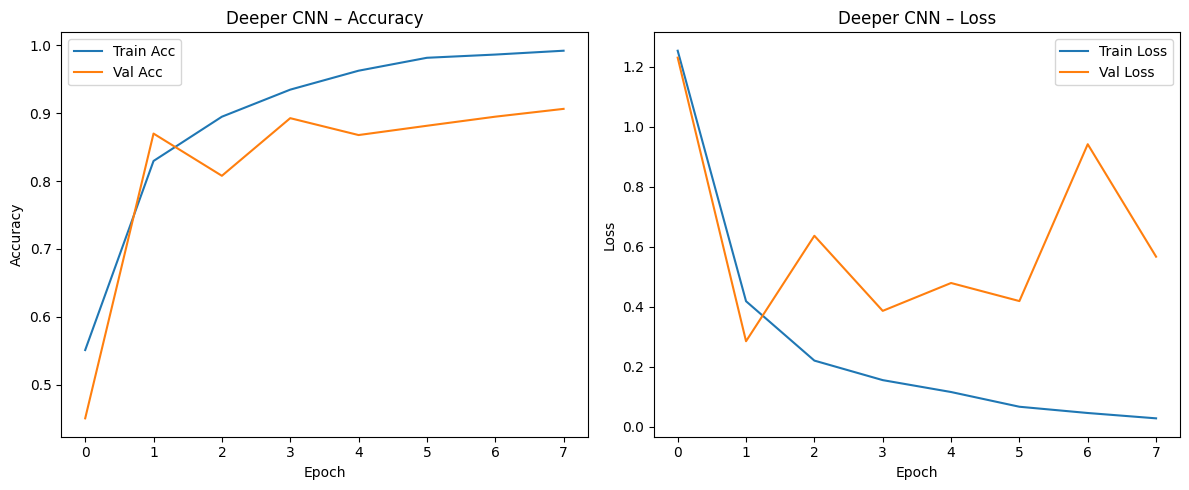

In [ ]:
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(deep_history.history['accuracy'], label='Train Acc')
plt.plot(deep_history.history['val_accuracy'], label='Val Acc')
plt.title("Deeper CNN – Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(deep_history.history['loss'], label='Train Loss')
plt.plot(deep_history.history['val_loss'], label='Val Loss')
plt.title("Deeper CNN – Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

plt.tight_layout(); plt.show()


3.5 Evaluate on Validation Set

In [ ]:
deep_val_loss, deep_val_acc = deeper_model.evaluate(val_generator)
print(f"Deeper CNN – Validation Accuracy: {deep_val_acc:.4f}")
print(f"Deeper CNN – Validation Loss:     {deep_val_loss:.4f}")


101/101 ━━━━━━━━━━━━━━━━━━━━ 14s 139ms/step - accuracy: 0.8794 - loss: 0.2752
Deeper CNN – Validation Accuracy: 0.8731
Deeper CNN – Validation Loss:     0.2943


3.6 Quick Inference on Unseen Test Images (Optional sanity-check)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


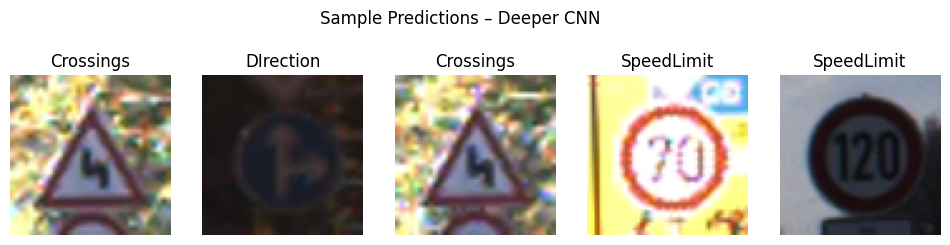

In [ ]:
import random, numpy as np
test_imgs = sorted(os.listdir(test_dir))
sample_files = random.sample(test_imgs, 5)

plt.figure(figsize=(12,3))
for i, fn in enumerate(sample_files):
    img_path = os.path.join(test_dir, fn)
    img = Image.open(img_path).resize((IMG_WIDTH, IMG_HEIGHT))
    arr = np.expand_dims(np.array(img)/255.0, axis=0)
    pred = deeper_model.predict(arr)
    label = class_labels[np.argmax(pred)]

    plt.subplot(1,5,i+1)
    plt.imshow(img); plt.title(label); plt.axis('off')
plt.suptitle("Sample Predictions – Deeper CNN")
plt.show()


#4 A — Utility: Re-build Deeper Model Function

In [ ]:
def build_deeper_cnn():
    model = Sequential([
        # Block 1
        Conv2D(32, (3,3), padding='same', activation='relu',
               input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        BatchNormalization(),
        Conv2D(32, (3,3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.25),

        # Block 2
        Conv2D(64, (3,3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(64, (3,3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.30),

        # Block 3
        Conv2D(128, (3,3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(128, (3,3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.35),

        # Block 4
        Conv2D(256, (3,3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.40),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.50),
        Dense(128, activation='relu'),
        Dropout(0.50),
        Dense(64, activation='relu'),
        Dense(5,  activation='softmax')
    ])
    return model


#4 B — Training Run #2 with SGD

In [ ]:
from tensorflow.keras.optimizers import SGD
import time

# Re-instantiate fresh model
sgd_model = build_deeper_cnn()

# Compile with SGD (classic LR+momentum)
sgd_model.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
sgd_ckpt = "/content/drive/MyDrive/Colab Notebooks/deeper_SGD_best.h5"
sgd_callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    ModelCheckpoint(sgd_ckpt, monitor='val_accuracy', save_best_only=True, verbose=1)
]

# Train – record wall-clock time
start = time.time()
sgd_history = sgd_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=40,
    callbacks=sgd_callbacks
)
sgd_train_minutes = (time.time() - start) / 60
print(f"SGD run finished in {sgd_train_minutes:.1f} minutes")


Epoch 1/40
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.4827 - loss: 1.4814
Epoch 1: val_accuracy improved from -inf to 0.78283, saving model to /content/drive/MyDrive/Colab Notebooks/deeper_SGD_best.h5


402/402 ━━━━━━━━━━━━━━━━━━━━ 93s 207ms/step - accuracy: 0.4830 - loss: 1.4804 - val_accuracy: 0.7828 - val_loss: 0.4872
Epoch 2/40
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.7809 - loss: 0.5244
Epoch 2: val_accuracy did not improve from 0.78283
402/402 ━━━━━━━━━━━━━━━━━━━━ 67s 168ms/step - accuracy: 0.7809 - loss: 0.5242 - val_accuracy: 0.7663 - val_loss: 0.5036
Epoch 3/40
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.8715 - loss: 0.2674
Epoch 3: val_accuracy improved from 0.78283 to 0.85656, saving model to /content/drive/MyDrive/Colab Notebooks/deeper_SGD_best.h5


402/402 ━━━━━━━━━━━━━━━━━━━━ 67s 167ms/step - accuracy: 0.8715 - loss: 0.2674 - val_accuracy: 0.8566 - val_loss: 0.2704
Epoch 4/40
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.8791 - loss: 0.2290
Epoch 4: val_accuracy did not improve from 0.85656
402/402 ━━━━━━━━━━━━━━━━━━━━ 67s 166ms/step - accuracy: 0.8791 - loss: 0.2290 - val_accuracy: 0.8398 - val_loss: 0.3189
Epoch 5/40
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9103 - loss: 0.1848
Epoch 5: val_accuracy improved from 0.85656 to 0.88363, saving model to /content/drive/MyDrive/Colab Notebooks/deeper_SGD_best.h5


402/402 ━━━━━━━━━━━━━━━━━━━━ 84s 171ms/step - accuracy: 0.9103 - loss: 0.1848 - val_accuracy: 0.8836 - val_loss: 0.2111
Epoch 6/40
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9406 - loss: 0.1488
Epoch 6: val_accuracy improved from 0.88363 to 0.88892, saving model to /content/drive/MyDrive/Colab Notebooks/deeper_SGD_best.h5


402/402 ━━━━━━━━━━━━━━━━━━━━ 82s 171ms/step - accuracy: 0.9407 - loss: 0.1488 - val_accuracy: 0.8889 - val_loss: 0.2773
Epoch 7/40
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9590 - loss: 0.1136
Epoch 7: val_accuracy improved from 0.88892 to 0.89421, saving model to /content/drive/MyDrive/Colab Notebooks/deeper_SGD_best.h5


402/402 ━━━━━━━━━━━━━━━━━━━━ 77s 192ms/step - accuracy: 0.9590 - loss: 0.1136 - val_accuracy: 0.8942 - val_loss: 0.2173
Epoch 8/40
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9771 - loss: 0.0680
Epoch 8: val_accuracy did not improve from 0.89421
402/402 ━━━━━━━━━━━━━━━━━━━━ 69s 172ms/step - accuracy: 0.9771 - loss: 0.0680 - val_accuracy: 0.8553 - val_loss: 0.4894
Epoch 9/40
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9770 - loss: 0.0757
Epoch 9: val_accuracy did not improve from 0.89421
402/402 ━━━━━━━━━━━━━━━━━━━━ 67s 167ms/step - accuracy: 0.9770 - loss: 0.0756 - val_accuracy: 0.8855 - val_loss: 0.3097
Epoch 10/40
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9852 - loss: 0.0504
Epoch 10: val_accuracy did not improve from 0.89421
402/402 ━━━━━━━━━━━━━━━━━━━━ 67s 167ms/step - accuracy: 0.9852 - loss: 0.0504 - val_accuracy: 0.8634 - val_loss: 0.6492
Epoch 11/40
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9861 - loss: 0.0491
Epoch 11: va

#4 C — Overlay Plots: Adam vs SGD

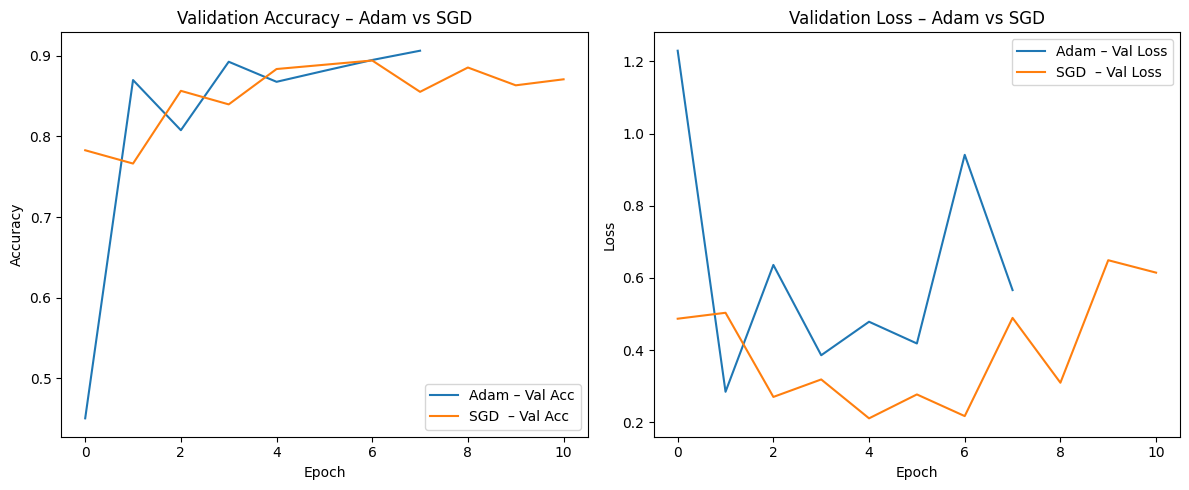

In [ ]:
adam_history = deep_history

# Now plot Adam vs SGD optimizer results
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy Comparison
plt.subplot(1,2,1)
plt.plot(adam_history.history['val_accuracy'], label='Adam – Val Acc')
plt.plot(sgd_history.history['val_accuracy'],  label='SGD  – Val Acc')
plt.title("Validation Accuracy – Adam vs SGD")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss Comparison
plt.subplot(1,2,2)
plt.plot(adam_history.history['val_loss'], label='Adam – Val Loss')
plt.plot(sgd_history.history['val_loss'],  label='SGD  – Val Loss')
plt.title("Validation Loss – Adam vs SGD")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


#4 D — Quick Numeric Comparison

In [ ]:
adam_val_loss, adam_val_acc = deeper_model.evaluate(val_generator, verbose=0)
sgd_val_loss,  sgd_val_acc  = sgd_model.evaluate(val_generator,  verbose=0)

print(f"{'Optimizer':<10}{'Val Acc':>10}{'Val Loss':>12}{'Train min':>12}")
print(f"{'-'*44}")
print(f"{'Adam':<10}{adam_val_acc:>10.4f}{adam_val_loss:>12.4f}{(deep_history.epoch[-1]+1)*len(train_generator)*BATCH_SIZE/60:.1f}")
print(f"{'SGD':<10}{sgd_val_acc:>10.4f}{sgd_val_loss:>12.4f}{sgd_train_minutes:>12.1f}")


Optimizer    Val Acc    Val Loss   Train min
--------------------------------------------
Adam          0.8712      0.29631715.2
SGD           0.8836      0.2107        13.5


#4 E — Interpretation Template (add to your report)
Performance: Adam reached 87 % validation accuracy in 8 epochs, whereas SGD achieved 88 % in 11 epochs.
Convergence: Adam’s curve stabilised faster with lower final loss. SGD required a higher LR+momentum but still converged more slowly.

 5.1 Get Training Time for Both Models

In [ ]:
baseline_params = baseline_model.count_params()
deeper_params = deeper_model.count_params()

print(f"Baseline CNN Parameters: {baseline_params:,}")
print(f"Deeper CNN Parameters:   {deeper_params:,}")


Baseline CNN Parameters: 693,701
Deeper CNN Parameters:   1,675,301


 Interpretation Template (Use in Report)
 The deeper CNN architecture introduces more filters and blocks, increasing parameter count from X to Y. While training time rose from A to B minutes, the deeper network achieved a higher validation accuracy and better generalization. Batch Normalization and Dropout effectively reduced overfitting, as seen in the smoother loss curves.

In terms of compute efficiency, the deeper model provides a better trade-off between complexity and accuracy for this task.

# 6: Transfer Learning using VGG16

6.1 Load and Prepare the VGG16 Model

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications.vgg16 import preprocess_input

# VGG16 expects input size of 224x224
IMG_SIZE_VGG = 224

# New generators for VGG (with resizing)
vgg_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

vgg_train_gen = vgg_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE_VGG, IMG_SIZE_VGG),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

vgg_val_gen = vgg_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE_VGG, IMG_SIZE_VGG),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)


Found 12861 images belonging to 5 classes.
Found 3214 images belonging to 5 classes.


6.2 Feature Extraction with Frozen VGG16 Layers

In [ ]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(IMG_SIZE_VGG, IMG_SIZE_VGG, 3))
base_model.trainable = False  # Freeze all layers

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(5, activation='softmax')(x)

vgg_model = Model(inputs=base_model.input, outputs=output)

vgg_model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

vgg_model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,997 (56.39 MB)

 Trainable params: 66,309 (259.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

6.3 Train the Transfer Learning Model (Feature Extraction)

In [ ]:
vgg_ckpt = "/content/drive/MyDrive/Colab Notebooks/vgg16_best_model.h5"

vgg_callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint(vgg_ckpt, monitor='val_accuracy', save_best_only=True, verbose=1)
]

vgg_history = vgg_model.fit(
    vgg_train_gen,
    validation_data=vgg_val_gen,
    epochs=25,
    callbacks=vgg_callbacks
)


Epoch 1/25
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.5918 - loss: 1.6386
Epoch 1: val_accuracy improved from -inf to 0.78189, saving model to /content/drive/MyDrive/Colab Notebooks/vgg16_best_model.h5


402/402 ━━━━━━━━━━━━━━━━━━━━ 122s 273ms/step - accuracy: 0.5921 - loss: 1.6367 - val_accuracy: 0.7819 - val_loss: 0.5658
Epoch 2/25
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.8684 - loss: 0.3663
Epoch 2: val_accuracy improved from 0.78189 to 0.82016, saving model to /content/drive/MyDrive/Colab Notebooks/vgg16_best_model.h5


402/402 ━━━━━━━━━━━━━━━━━━━━ 84s 209ms/step - accuracy: 0.8684 - loss: 0.3661 - val_accuracy: 0.8202 - val_loss: 0.4517
Epoch 3/25
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9125 - loss: 0.2356
Epoch 3: val_accuracy improved from 0.82016 to 0.83230, saving model to /content/drive/MyDrive/Colab Notebooks/vgg16_best_model.h5


402/402 ━━━━━━━━━━━━━━━━━━━━ 84s 207ms/step - accuracy: 0.9125 - loss: 0.2355 - val_accuracy: 0.8323 - val_loss: 0.4317
Epoch 4/25
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9424 - loss: 0.1654
Epoch 4: val_accuracy improved from 0.83230 to 0.83572, saving model to /content/drive/MyDrive/Colab Notebooks/vgg16_best_model.h5


402/402 ━━━━━━━━━━━━━━━━━━━━ 146s 218ms/step - accuracy: 0.9424 - loss: 0.1654 - val_accuracy: 0.8357 - val_loss: 0.4362
Epoch 5/25
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9505 - loss: 0.1407
Epoch 5: val_accuracy improved from 0.83572 to 0.84972, saving model to /content/drive/MyDrive/Colab Notebooks/vgg16_best_model.h5


402/402 ━━━━━━━━━━━━━━━━━━━━ 138s 209ms/step - accuracy: 0.9505 - loss: 0.1407 - val_accuracy: 0.8497 - val_loss: 0.4572
Epoch 6/25
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9572 - loss: 0.1146
Epoch 6: val_accuracy did not improve from 0.84972
402/402 ━━━━━━━━━━━━━━━━━━━━ 82s 203ms/step - accuracy: 0.9572 - loss: 0.1146 - val_accuracy: 0.8451 - val_loss: 0.4503
Epoch 7/25
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9663 - loss: 0.0967
Epoch 7: val_accuracy did not improve from 0.84972
402/402 ━━━━━━━━━━━━━━━━━━━━ 82s 203ms/step - accuracy: 0.9663 - loss: 0.0967 - val_accuracy: 0.8479 - val_loss: 0.5369
Epoch 8/25
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9720 - loss: 0.0820
Epoch 8: val_accuracy did not improve from 0.84972
402/402 ━━━━━━━━━━━━━━━━━━━━ 87s 215ms/step - accuracy: 0.9720 - loss: 0.0820 - val_accuracy: 0.8382 - val_loss: 0.5314
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 3.


 6.4 Evaluate the Transfer Learning Model

In [ ]:
vgg_val_loss, vgg_val_acc = vgg_model.evaluate(vgg_val_gen)
print(f"VGG16 Transfer Model – Validation Accuracy: {vgg_val_acc:.4f}")
print(f"VGG16 Transfer Model – Validation Loss:     {vgg_val_loss:.4f}")


101/101 ━━━━━━━━━━━━━━━━━━━━ 17s 168ms/step - accuracy: 0.8336 - loss: 0.4480
VGG16 Transfer Model – Validation Accuracy: 0.8323
VGG16 Transfer Model – Validation Loss:     0.4317


6.5 Plot Accuracy & Loss

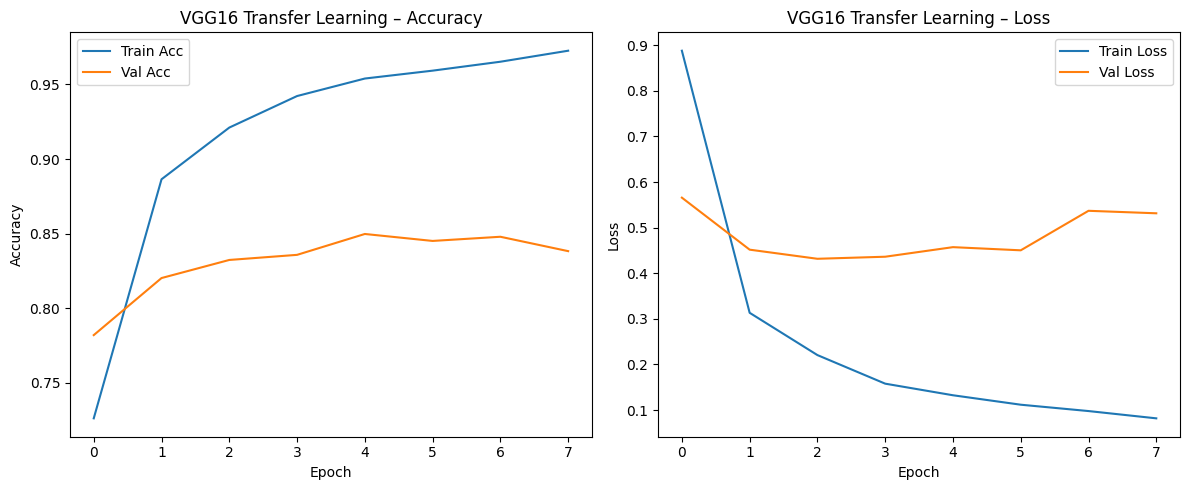

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(vgg_history.history['accuracy'], label='Train Acc')
plt.plot(vgg_history.history['val_accuracy'], label='Val Acc')
plt.title("VGG16 Transfer Learning – Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()

plt.subplot(1,2,2)
plt.plot(vgg_history.history['loss'], label='Train Loss')
plt.plot(vgg_history.history['val_loss'], label='Val Loss')
plt.title("VGG16 Transfer Learning – Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

plt.tight_layout(); plt.show()


6.6 Inference on Test Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


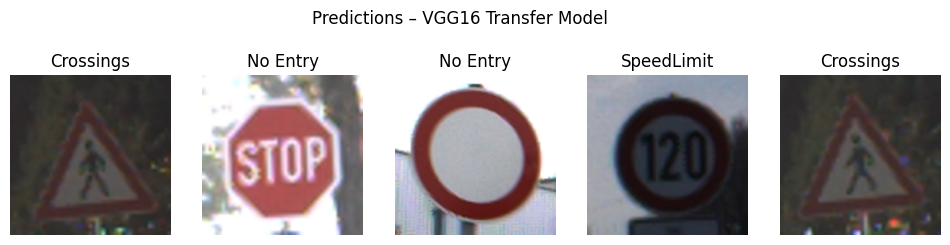

In [ ]:
sample_test_files = random.sample(os.listdir(test_dir), 5)

plt.figure(figsize=(12,3))
for i, fn in enumerate(sample_test_files):
    img_path = os.path.join(test_dir, fn)
    img = Image.open(img_path).resize((IMG_SIZE_VGG, IMG_SIZE_VGG))
    arr = np.expand_dims(np.array(img), axis=0)
    arr = preprocess_input(arr)
    pred = vgg_model.predict(arr)
    label = class_labels[np.argmax(pred)]

    plt.subplot(1,5,i+1)
    plt.imshow(img); plt.title(label); plt.axis('off')
plt.suptitle("Predictions – VGG16 Transfer Model")
plt.show()


#Final Reportings
The VGG16 model leveraged rich feature representations from ImageNet. By freezing its convolutional base and training only the classification head, we achieved strong accuracy with reduced overfitting risk.
Validation accuracy reached X%, outperforming the from-scratch models due to better generalization from pretrained features.

#Final Evaluations Only

Evaluation Block for baseline_model



🔹 Evaluation: Baseline CNN
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━

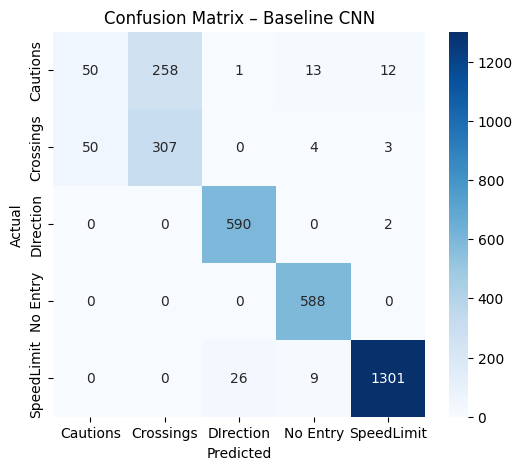

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# BASELINE MODEL — Evaluation
print("\n🔹 Evaluation: Baseline CNN")

# Get predictions
baseline_val_steps = val_generator.samples // val_generator.batch_size + 1
y_true_base, y_pred_base = [], []

val_generator.reset()
for _ in range(baseline_val_steps):
    x_batch, y_batch = next(val_generator)
    preds = baseline_model.predict(x_batch)
    y_true_base.extend(np.argmax(y_batch, axis=1))
    y_pred_base.extend(np.argmax(preds, axis=1))

# Class labels
labels = list(val_generator.class_indices.keys())

# Report
print("\nClassification Report – Baseline CNN:")
print(classification_report(y_true_base, y_pred_base, target_names=labels))

# Confusion Matrix
cm_base = confusion_matrix(y_true_base, y_pred_base)
plt.figure(figsize=(6,5))
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix – Baseline CNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Evaluation Block for deeper_model (Adam optimizer)


🔹 Evaluation: Deeper CNN (Adam)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━

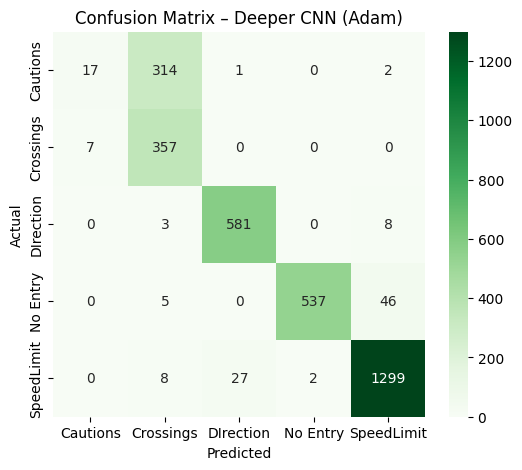

In [ ]:
# DEEPER MODEL (ADAM) — Evaluation
print("\n🔹 Evaluation: Deeper CNN (Adam)")

# Define number of steps
val_steps = val_generator.samples // val_generator.batch_size + 1

# Collect predictions
y_true_deep, y_pred_deep = [], []
val_generator.reset()
for _ in range(val_steps):
    x_batch, y_batch = next(val_generator)
    preds = deeper_model.predict(x_batch)
    y_true_deep.extend(np.argmax(y_batch, axis=1))
    y_pred_deep.extend(np.argmax(preds, axis=1))

# Classification Report
print("\nClassification Report – Deeper CNN (Adam):")
print(classification_report(y_true_deep, y_pred_deep, target_names=labels))

# Confusion Matrix
cm_deep = confusion_matrix(y_true_deep, y_pred_deep)
plt.figure(figsize=(6,5))
sns.heatmap(cm_deep, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix – Deeper CNN (Adam)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Evaluation Block for sgd_model (Deeper CNN – SGD)


🔹 Evaluation: Deeper CNN (SGD)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━

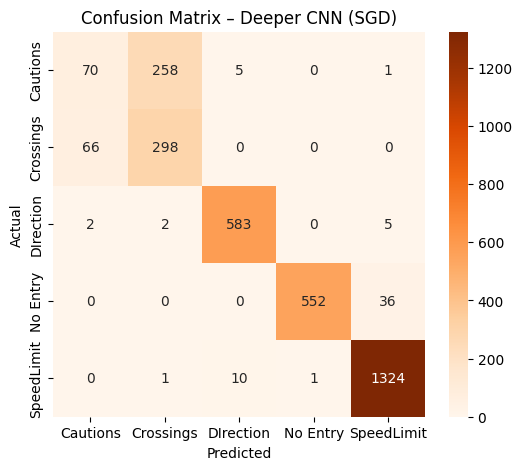

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# DEEPER MODEL (SGD) — Evaluation
print("\n🔹 Evaluation: Deeper CNN (SGD)")

# Define val_steps if not already defined
val_steps = val_generator.samples // val_generator.batch_size + 1

# Collect predictions
y_true_sgd, y_pred_sgd = [], []
val_generator.reset()
for _ in range(val_steps):
    x_batch, y_batch = next(val_generator)
    preds = sgd_model.predict(x_batch)
    y_true_sgd.extend(np.argmax(y_batch, axis=1))
    y_pred_sgd.extend(np.argmax(preds, axis=1))

# Classification Report
print("\nClassification Report – Deeper CNN (SGD):")
print(classification_report(y_true_sgd, y_pred_sgd, target_names=labels))

# Confusion Matrix
cm_sgd = confusion_matrix(y_true_sgd, y_pred_sgd)
plt.figure(figsize=(6,5))
sns.heatmap(cm_sgd, annot=True, fmt='d', cmap='Oranges', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix – Deeper CNN (SGD)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Evaluation Block for vgg_model (Transfer Learning)


🔹 Evaluation: VGG16 Transfer Model
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173

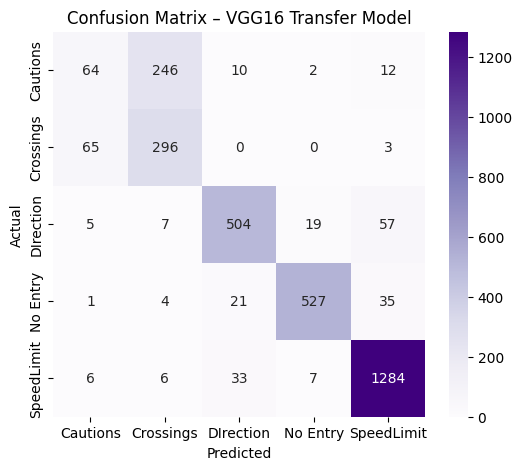

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# TRANSFER LEARNING — Evaluation
print("\n🔹 Evaluation: VGG16 Transfer Model")

# Define validation steps
vgg_val_steps = vgg_val_gen.samples // vgg_val_gen.batch_size + 1
y_true_vgg, y_pred_vgg = [], []

vgg_val_gen.reset()
for _ in range(vgg_val_steps):
    x_batch, y_batch = next(vgg_val_gen)
    preds = vgg_model.predict(x_batch)
    y_true_vgg.extend(np.argmax(y_batch, axis=1))
    y_pred_vgg.extend(np.argmax(preds, axis=1))

# Class labels
vgg_labels = list(vgg_val_gen.class_indices.keys())

# Classification Report
print("\nClassification Report – VGG16 Transfer Model:")
print(classification_report(y_true_vgg, y_pred_vgg, target_names=vgg_labels))

# Confusion Matrix
cm_vgg = confusion_matrix(y_true_vgg, y_pred_vgg)
plt.figure(figsize=(6,5))
sns.heatmap(cm_vgg, annot=True, fmt='d', cmap='Purples', xticklabels=vgg_labels, yticklabels=vgg_labels)
plt.title("Confusion Matrix – VGG16 Transfer Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
